In [1]:
import csv
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import squarify
import seaborn as sns

In [ ]:
raw_data = os.path.join(os.getcwd(), 'task10', 'raw_data.csv')
processed_data = 'processed_data.csv'

# Read, process, and write to a new CSV
with open(raw_data, mode='r', encoding='utf-8') as infile, \
     open(processed_data, mode='w', newline='', encoding='utf-8') as outfile:

    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    # Write the header
    writer.writerow(['Company', 'Industry'])

    # Process each row
    for row in reader:
        entry = row[0].strip()  # Get the single column and strip whitespace
        if "|" in entry:
            company, industry = map(str.strip, entry.split('|'))
            writer.writerow([company, industry])

print(f"Data has been successfully processed and written to {processed_data}")

In [62]:
# Load the data
filepath = 'processed_data.csv'  # Replace with the actual file path
df = pd.read_csv(filepath)

In [40]:
# Inspect the data
print(df.shape)
print(df.columns)
df.head(10)

(193, 2)
Index(['Company', 'Industry'], dtype='object')


,Company,Industry
0,#67,Telephone Utilities
1,46andMix,Other
2,A_Connect,Education
3,AA,Computer Software
4,Abstract,Internet
5,Adonis,Health
6,Ahonetwo,Business Services
7,AI HR APP,Computer Software
8,AIID,"Builders/Residential, Computer Software"
9,ANAKIN,Internet


In [41]:
df.describe()

,Company,Industry
count,193,193
unique,193,73
top,#67,Other
freq,1,32


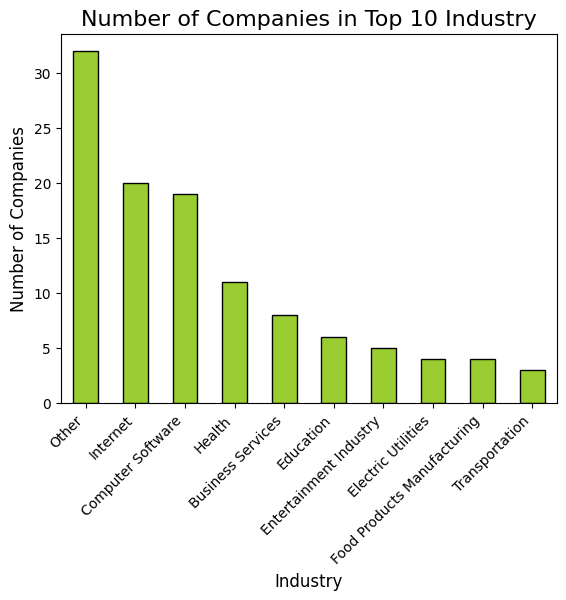

In [ ]:
# Bar chart showing the number of companies in top 10 industry
industry_counts_top10 = df['Industry'].value_counts().head(10)
industry_counts_top10.plot(kind='bar', color='yellowgreen', edgecolor='black')
plt.title('Number of Companies in Top 10 Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

Text(0, 0.5, '')

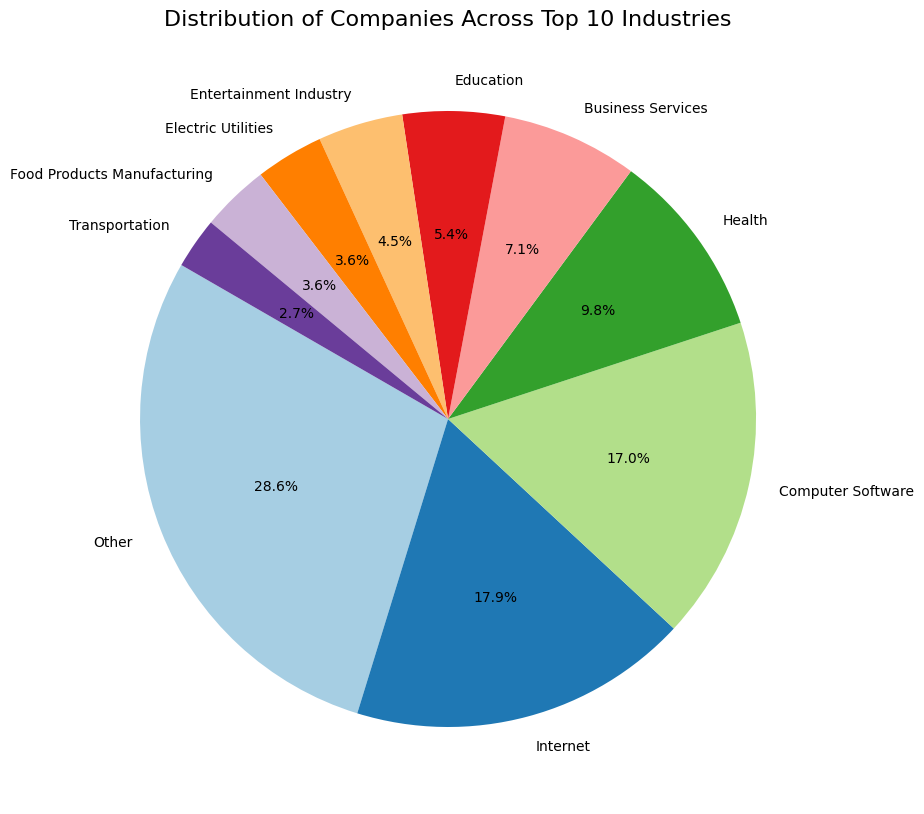

In [ ]:
# Pie Chart: Percentage Distribution of Companies Across Industries
plt.figure(figsize=(10, 10))
industry_counts_top10.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=plt.cm.Paired.colors)
plt.title('Distribution of Companies Across Top 10 Industries', fontsize=16)
plt.ylabel('')  # Hides the y-label for the pie chart

(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(100.0))

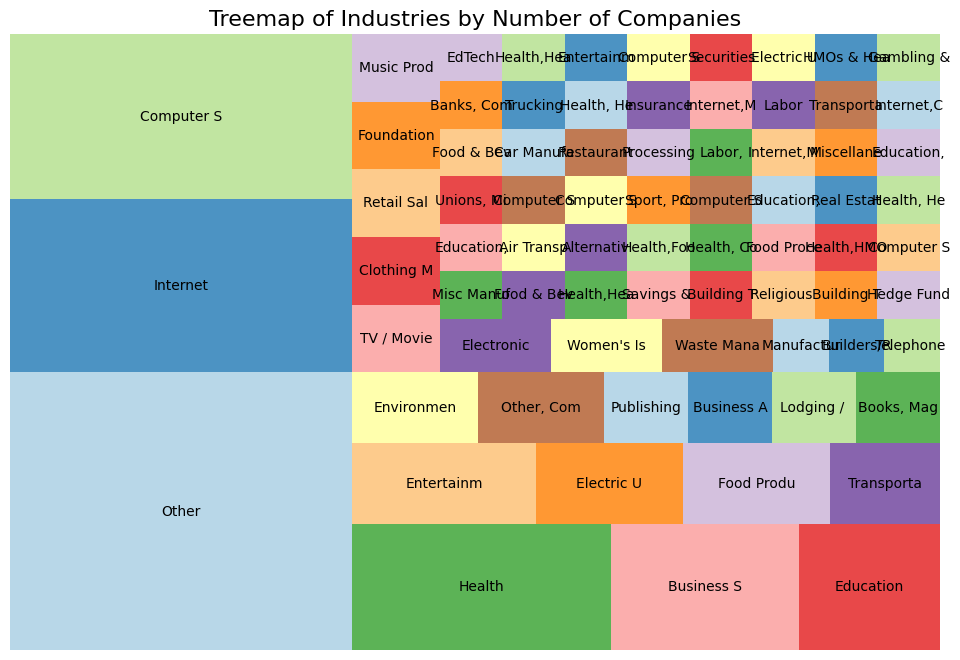

In [ ]:
# Prepare data for treemap
industry_counts = df['Industry'].value_counts()
sizes = industry_counts.values
labels = industry_counts.index

# Truncate long industry names
max_label_length = 10  # Adjust as needed
labels = [label[:max_label_length] + '' if len(label) > max_label_length else label for label in labels]

# Treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=plt.cm.Paired.colors)
plt.title('Treemap of Industries by Number of Companies', fontsize=16)
plt.axis('off')  # Remove axes for a cleaner look

In [5]:
import networkx as nx
from collections import defaultdict

In [101]:
def create_industry_network():
    G = nx.Graph()
    industry_connections = defaultdict(int)

    for _, row in df.iterrows():
        industries = [ind.strip() for ind in row['Industry'].split(',')]
        if len(industries) > 1:
            for i in range(len(industries)):
                for j in range(i + 1, len(industries)):
                    pair = tuple(sorted([industries[i], industries[j]]))
                    industry_connections[pair] += 1

    unique_industries = set()
    for pair in industry_connections:
        unique_industries.add(pair[0])
        unique_industries.add(pair[1])

    for industry in unique_industries:
        company_count = df['Industry'].str.contains(industry).sum()
        G.add_node(industry, size=company_count)

    for (ind1, ind2), weight in industry_connections.items():
        G.add_edge(ind1, ind2, weight=weight)

    return G

In [102]:
def adjust_positions(pos, min_dist=0.1, max_iterations=50):
    pos_array = np.array([pos[node] for node in pos])

    adjusted = True
    iteration = 0

    while adjusted and iteration < max_iterations:
        iteration += 1
        adjusted = False
        dx = pos_array[:, 0, np.newaxis] - pos_array[:, 0]
        dy = pos_array[:, 1, np.newaxis] - pos_array[:, 1]
        dist = np.sqrt(dx**3 + dy**3)

        np.fill_diagonal(dist, np.inf)

        close_pairs = dist < min_dist

        for i, j in zip(*np.where(close_pairs)):
            if i < j:
                factor = (min_dist - dist[i, j]) / dist[i, j] / 2
                dx_ij, dy_ij = dx[i, j], dy[i, j]
                pos_array[i, 0] += dx_ij * factor
                pos_array[i, 1] += dy_ij * factor
                pos_array[j, 0] -= dx_ij * factor
                pos_array[j, 1] -= dy_ij * factor
                adjusted = True

    new_pos = {node: pos_array[i] for i, node in enumerate(pos)}
    return new_pos


In [109]:
def draw_network(G):
    np.random.seed(42)

    # Create figure
    plt.figure(figsize=(17, 17))

    pos = nx.spring_layout(G, k=2, iterations=100, seed=42)

    # Adjust node positions to prevent overlap
    pos = adjust_positions(pos)

    # Draw edges
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.4, edge_color='olive')

    # Draw nodes
    node_sizes = [G.nodes[node]['size'] * 200 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='gold', alpha=0.7)

    # Add labels with adjusted font size and position
    label_pos = {}
    for k, v in pos.items():
        # Dynamically adjust label position with additional offset
        label_pos[k] = [v[0] + np.random.uniform(-0.02, 0.02), v[1] + np.random.uniform(-0.02, 0.02)]

    nx.draw_networkx_labels(G, label_pos, font_size=8, font_weight='bold')

    # Add title and remove axes
    plt.title('Industry Relationship Network', fontsize=20)
    plt.axis('off')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    plt.show()

<ipython-input-102-3f241922cc92>:12: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(dx**3 + dy**3)


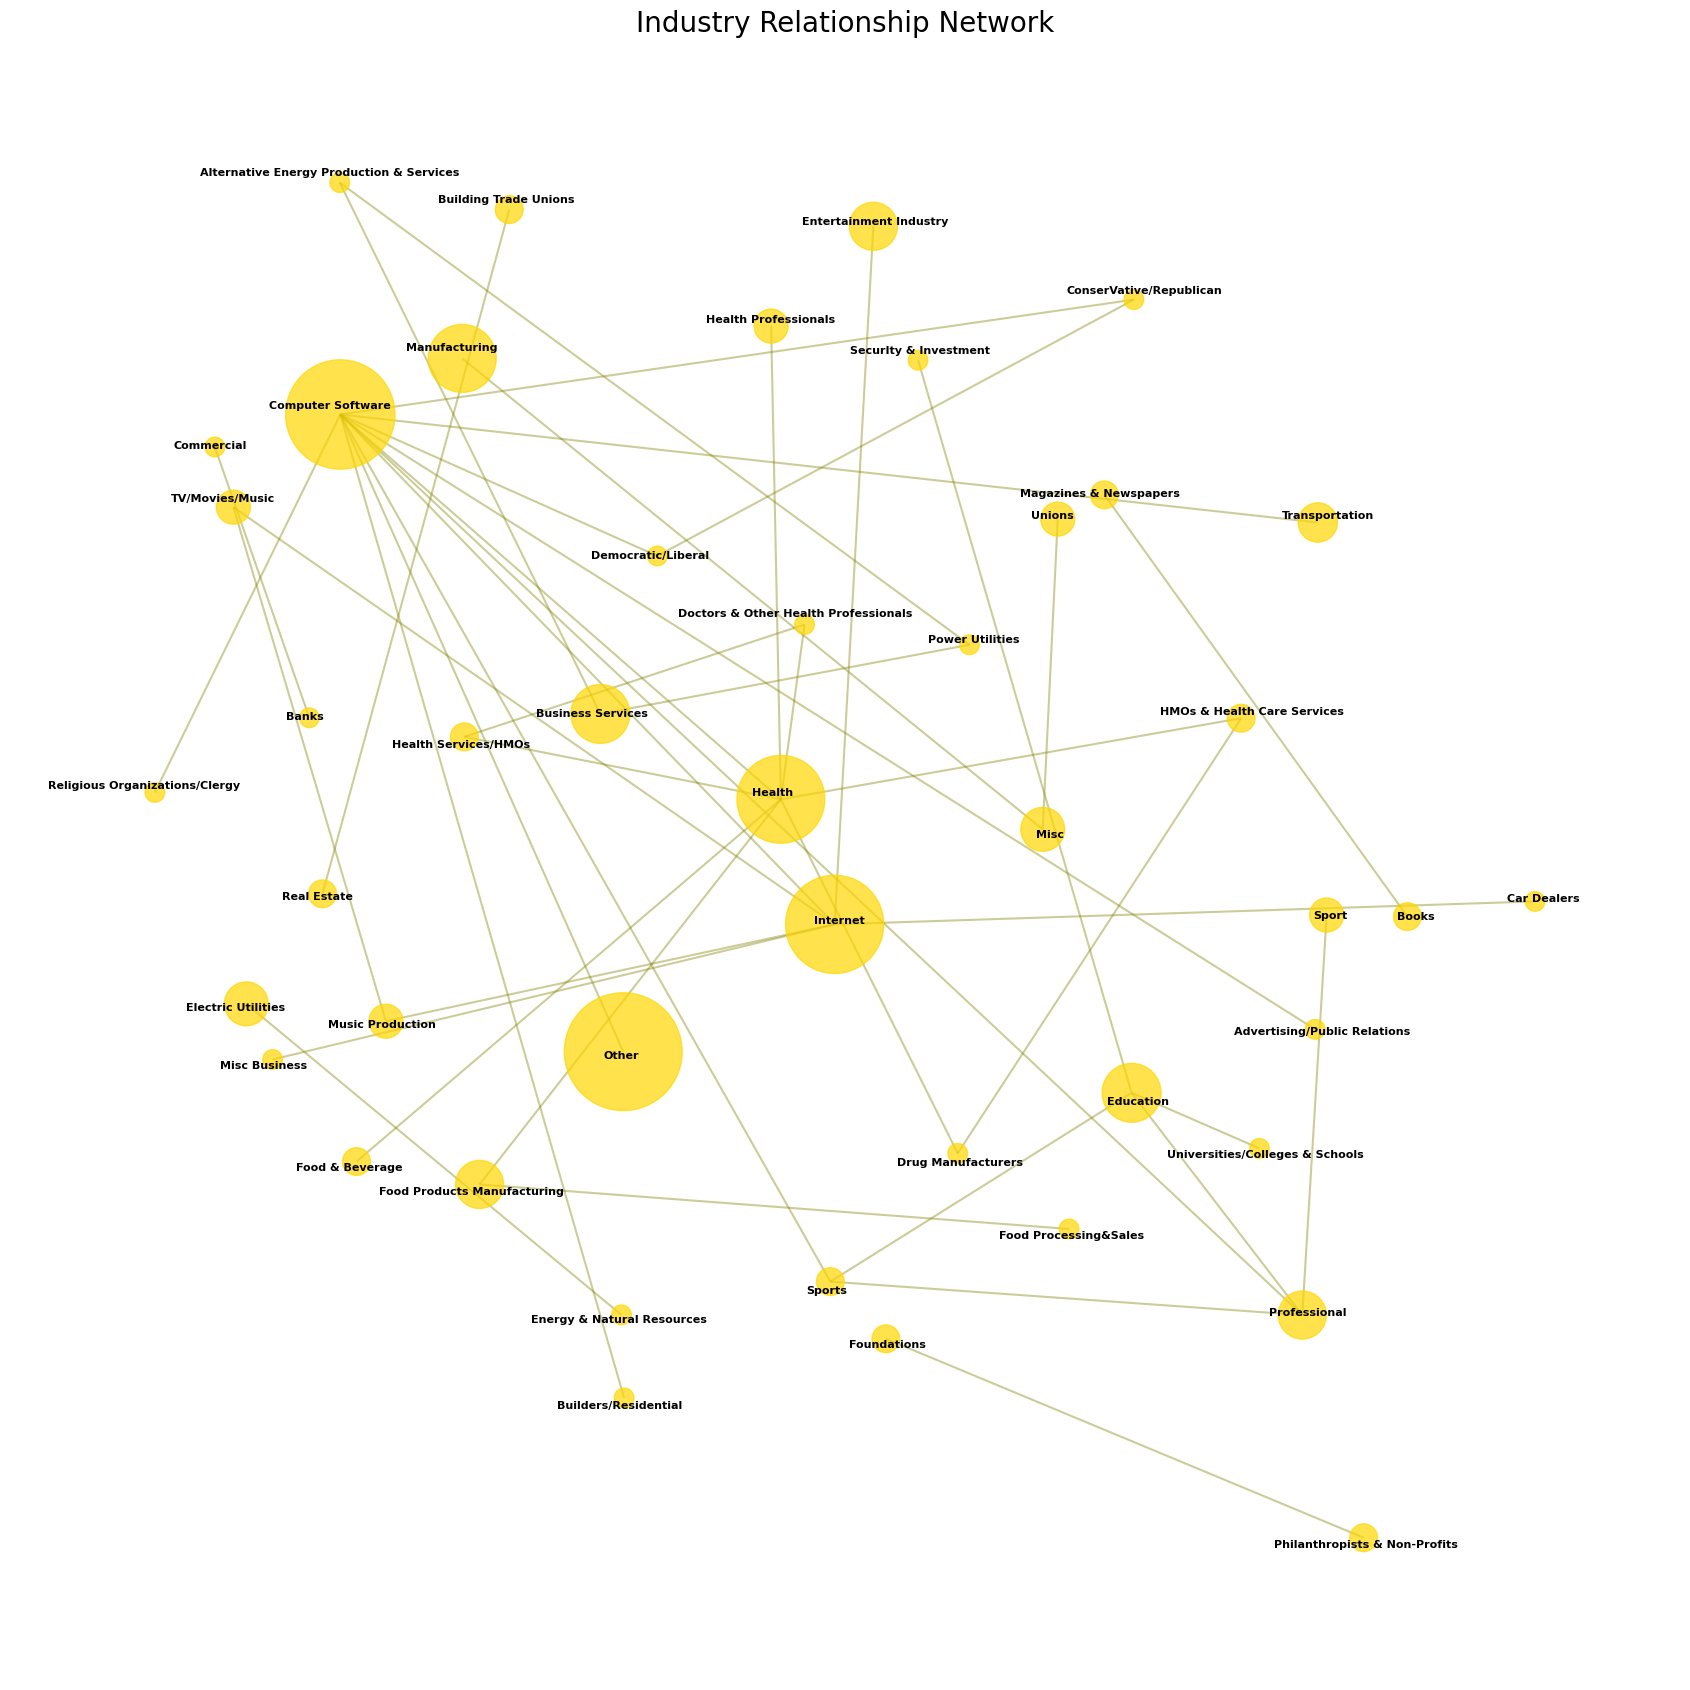

In [110]:
# Create and visualize the network
G = create_industry_network()
draw_network(G)